# 0. import the necessary packages

In [109]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
from pandas.core.common import SettingWithCopyWarning
from pandas_profiling import ProfileReport
from pathlib import Path
from scipy.stats import probplot, chi2_contingency, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from imblearn.over_sampling import SMOTE
import joblib
%matplotlib inline

# 1. Get the data

In [299]:
#import csv file
cc_data_full_data = pd.read_csv('dataset/application_record.csv')
credit_status = pd.read_csv('dataset/credit_record.csv')

In [111]:
# creating the target variable
begin_month=pd.DataFrame(credit_status.groupby(['ID'])['MONTHS_BALANCE'].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'Account age'})
cc_data_full_data=pd.merge(cc_data_full_data,begin_month,how='left',on='ID')
credit_status['dep_value'] = None
credit_status['dep_value'][credit_status['STATUS'] =='2']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='3']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='4']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='5']='Yes'
cpunt=credit_status.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes'
cpunt['dep_value'][cpunt['dep_value'] == 0]='No'
cpunt = cpunt[['dep_value']]
cc_data_full_data = pd.merge(cc_data_full_data,cpunt,how='inner',on='ID')
cc_data_full_data['Is high risk']=cc_data_full_data['dep_value']
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='Yes','Is high risk']=1
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='No','Is high risk']=0
cc_data_full_data.drop('dep_value',axis=1,inplace=True)
warnings.simplefilter(action='always', category=SettingWithCopyWarning)

/var/folders/bb/dzx22n7n1t1gkqfhhky4j2ch0000gn/T/ipykernel_38251/2110769735.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_status['dep_value'][credit_status['STATUS'] =='2']='Yes'
/var/folders/bb/dzx22n7n1t1gkqfhhky4j2ch0000gn/T/ipykernel_38251/2110769735.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_status['dep_value'][credit_status['STATUS'] =='3']='Yes'
/var/folders/bb/dzx22n7n1t1gkqfhhky4j2ch0000gn/T/ipykernel_38251/2110769735.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

In [112]:
# change the account in months
cc_data_full_data['Account age'] = np.abs(cc_data_full_data['Account age']).astype('int32')

In [233]:
# rename the columns to a more readable format
cc_data_full_data = cc_data_full_data.rename(columns={
    'CODE_GENDER':'Gender',
    'FLAG_OWN_CAR':'Has a car',
    'FLAG_OWN_REALTY':'Has a property',
    'CNT_CHILDREN':'Children count',
    'AMT_INCOME_TOTAL':'Income',
    'NAME_INCOME_TYPE':'Employment type',
    'NAME_EDUCATION_TYPE':'Education level',
    'NAME_FAMILY_STATUS':'Marital status',
    'NAME_HOUSING_TYPE':'Dwelling',
    'DAYS_BIRTH':'Age in days',
    'DAYS_EMPLOYED': 'Employment length in days',
    'FLAG_MOBIL': 'Has a mobile phone',
    'FLAG_WORK_PHONE': 'Has a work phone',
    'FLAG_PHONE': 'Has a phone',
    'FLAG_EMAIL': 'Has an email',
    'OCCUPATION_TYPE': 'Job title',
    'CNT_FAM_MEMBERS': 'Family member count',
    'Account age': 'Account age in months'
})

In [114]:
# split the data into train and test
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [115]:
cc_train_original, cc_test_original = data_split(cc_data_full_data, 0.2)

In [116]:
cc_train_original.shape

(29165, 20)

In [117]:
cc_test_original.shape

(7292, 20)

In [300]:
# creating a copy of the dataset so that the original stays untouched
cc_train_copy = cc_train_original.copy()
cc_test_copy = cc_test_original.copy()

# Explore the Data

In [119]:
cc_data_full_data.head()

,ID,Gender,Has a car,Has a property,Children count,Income,Employment type,Education level,Marital status,Dwelling,Age in days,Employment lenght in days,Has a mobile phone,Has a work phone,Has a phone,Has an email,Job title,Family member count,Account age in months,Is high risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,15,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,14,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,29,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,4,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,26,0


In [120]:
cc_data_full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         36457 non-null  int64  
 1   Gender                     36457 non-null  object 
 2   Has a car                  36457 non-null  object 
 3   Has a property             36457 non-null  object 
 4   Children count             36457 non-null  int64  
 5   Income                     36457 non-null  float64
 6   Employment type            36457 non-null  object 
 7   Education level            36457 non-null  object 
 8   Marital status             36457 non-null  object 
 9   Dwelling                   36457 non-null  object 
 10  Age in days                36457 non-null  int64  
 11  Employment lenght in days  36457 non-null  int64  
 12  Has a mobile phone         36457 non-null  int64  
 13  Has a work phone           36457 non-null  int

In [121]:
cc_data_full_data.describe()

,ID,Children count,Income,Age in days,Employment lenght in days,Has a mobile phone,Has a work phone,Has a phone,Has an email,Family member count,Account age in months
count,3.645700e+04,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.430315,1.866857e+05,-15975.173382,59262.935568,1.0,0.225526,0.294813,0.089722,2.198453,26.164193
std,4.187524e+04,0.742367,1.017892e+05,4200.549944,137651.334859,0.0,0.417934,0.455965,0.285787,0.911686,16.501854
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
25%,5.042028e+06,0.000000,1.215000e+05,-19438.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,12.000000
50%,5.074614e+06,0.000000,1.575000e+05,-15563.000000,-1552.000000,1.0,0.000000,0.000000,0.000000,2.000000,24.000000
75%,5.115396e+06,1.000000,2.250000e+05,-12462.000000,-408.000000,1.0,0.000000,1.000000,0.000000,3.000000,39.000000
max,5.150487e+06,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,60.000000


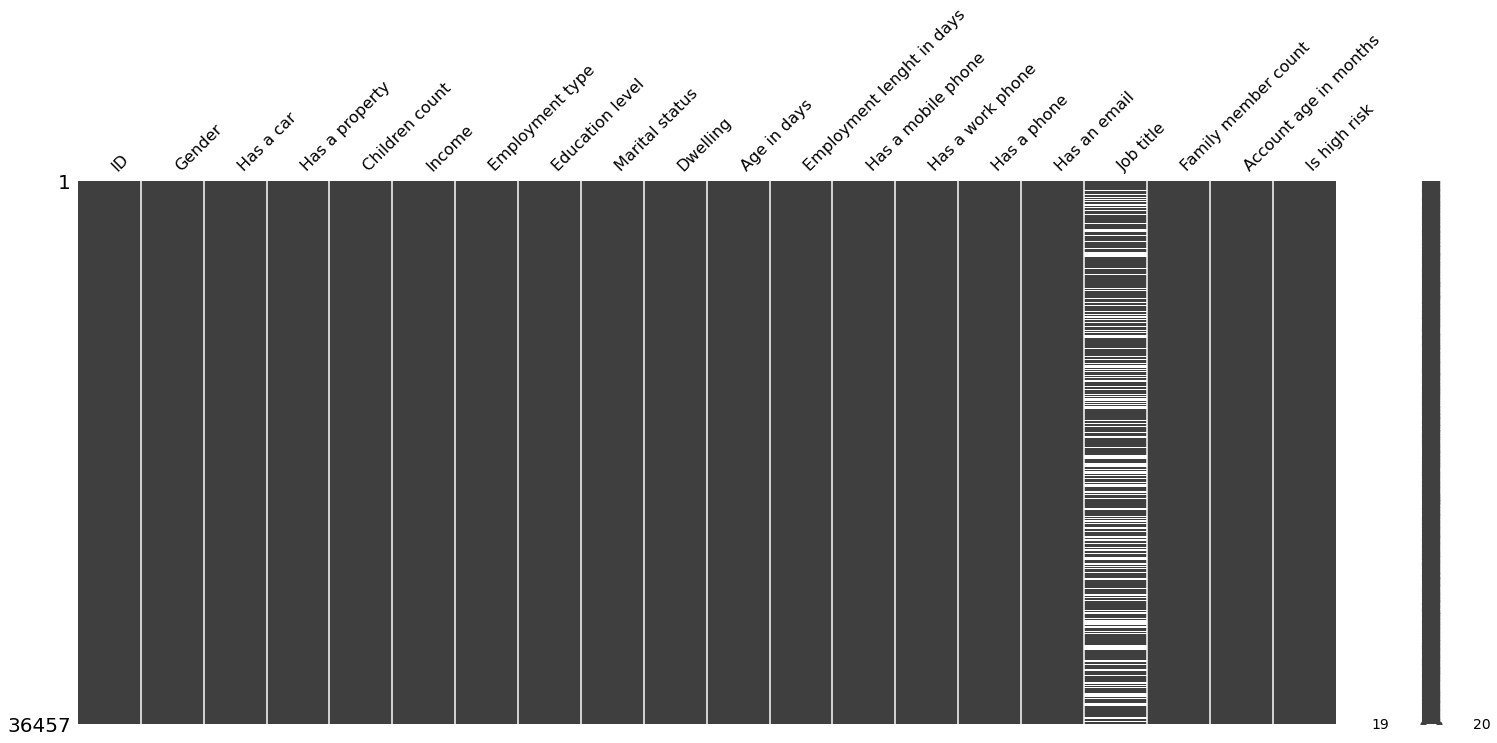

In [122]:
msno.matrix(cc_data_full_data)
plt.show()

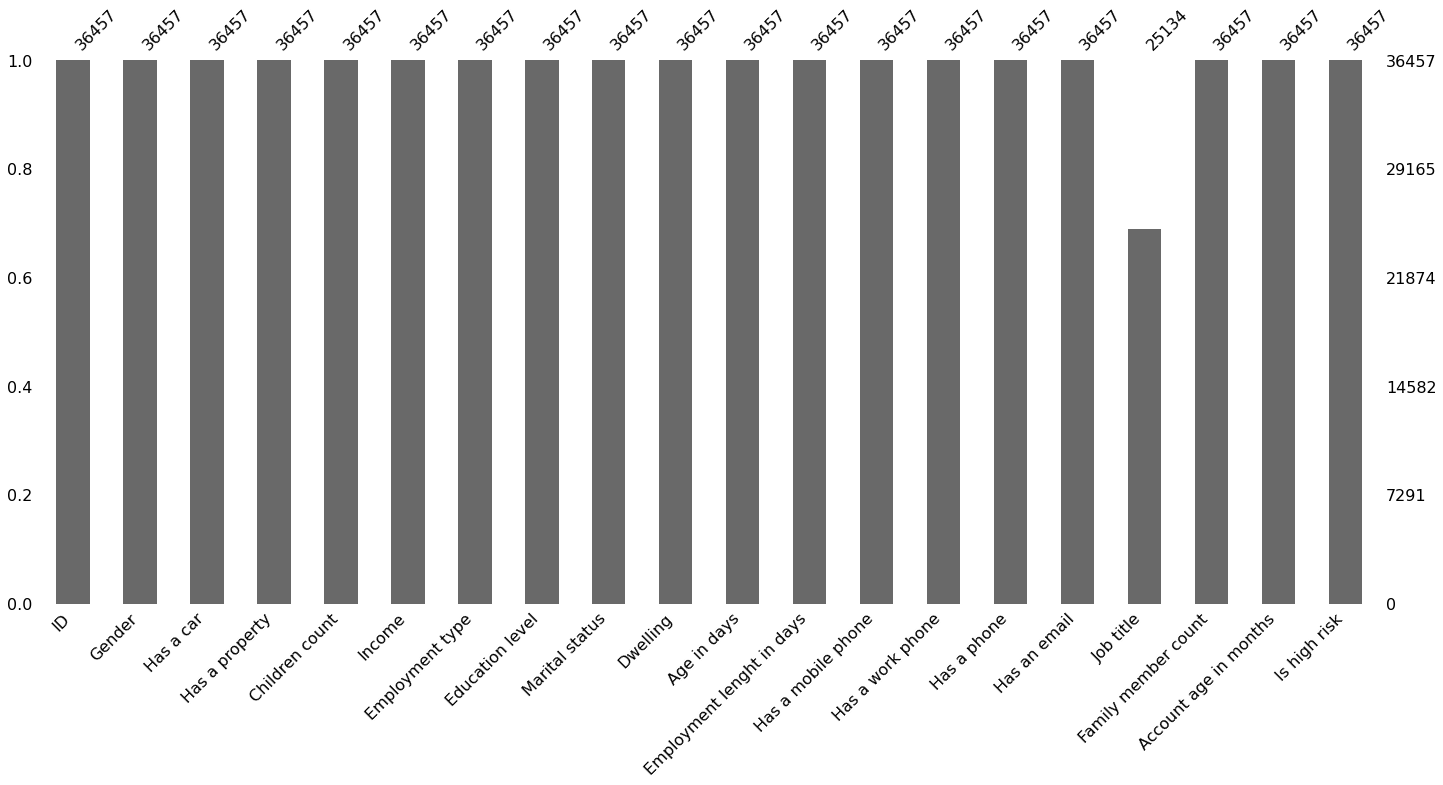

In [123]:
msno.bar(cc_data_full_data)
plt.show()

In [124]:
#Function that will return the value count and frequency of each observation within a column
def value_cnt_norm_cal(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

In [308]:
# function to create display general information about the feature
def gen_info_feat(df,feature):
    if feature in ['Age in days']:
        print('Description:\n{}'.format((np.abs(df[feature])/365.25).describe()))
        print('*'*50)
        print('Object type:{}'.format(df[feature].dtype))
    else:
        print('Description:\n{}'.format(df[feature].describe()))
        print('*'*50)
        print('Object type:\n{}'.format(df[feature].dtype))
        print('*'*50)
        value_cnt = value_cnt_norm_cal(df,feature)
        print('Value count:\n{}'.format(value_cnt))


In [274]:
# function to create a pie chart plot
def create_pie_plot(df,feature):
    ratio_size = value_cnt_norm_cal(df, feature)
    ratio_size_len = len(ratio_size.index)
    ratio_list = []
    for i in range(ratio_size_len):
        ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
    fig, ax = plt.subplots(figsize=(10,10))
    plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%', startangle=90)
    plt.axis('equal')
    return plt.show()

In [270]:
# function to create a bar chart plot
def create_bar_plot(df,feature):
    fig, ax = plt.subplots(figsize=(6,10))
    sns.barplot(x=cc_train_copy[feature].value_counts().index,y=cc_train_copy[feature].value_counts().values)
    ax.set_xticklabels(labels=df[feature].value_counts().index,rotation=45,ha='right')
    plt.xlabel('{}'.format(feature))
    plt.ylabel('Count')
    plt.title('{} count'.format(feature))
    plt.show()

In [297]:
# function to create a box plot
def create_box_plot(df,feature):
    fig, ax = plt.subplots(figsize=(2,8))
    sns.boxplot(y=np.abs(df[feature])/365.25)
    plt.title('{} distribution(Boxplot)'.format(feature))
    return plt.show()

In [302]:
# function to create a histogram plot
def create_hist_plot(df,feature):
    if feature == 'Age in days':
        fig, ax = plt.subplots(figsize=(18,10))
        sns.histplot(np.abs(df[feature])/365.25,bins=50,kde=True)
        plt.title('{} distribution'.format(feature))
        return plt.show()
    elif feature == 'Income':
        fig, ax = plt.subplots(figsize=(18,10))
        sns.histplot(df[feature],bins=50,kde=True)
        # suppress scientific notation
        ax.get_xaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        plt.title('{} distribution'.format(feature))
        return plt.show()
    else:
        fig, ax = plt.subplots(figsize=(18,10))
        sns.histplot(df[feature],bins=50,kde=True)
        plt.title('{} distribution'.format(feature))
        return plt.show()

In [304]:
# High risk vs low risk applicants compared with the feature on a box plot
def low_high_risk_box_plot(df,feature):
    if feature == 'Age in days':
        print(np.abs(cc_train_copy.groupby('Is high risk')[feature].mean()/365.25))
        # High risk vs low risk applicants compared by age
        fig, ax = plt.subplots(figsize=(5,8))
        sns.boxplot(y=np.abs(cc_train_copy[feature])/365.25,x=cc_train_copy['Is high risk'])
        plt.xticks(ticks=[0,1],labels=['no','yes'])
        plt.title('High risk individuals grouped by age')
        return plt.show()
    else:
        print(np.abs(cc_train_copy.groupby('Is high risk')[feature].mean()))
        fig, ax = plt.subplots(figsize=(5,8))
        sns.boxplot(y=np.abs(cc_train_copy[feature]),x=cc_train_copy['Is high risk'])
        plt.xticks(ticks=[0,1],labels=['no','yes'])
        plt.title('High risk individuals grouped by {}'.format(feature))
        return plt.show()

In [ ]:
# High risk vs low risk applicants compared with the feature on a bar plot

## 1. Gender

In [290]:
gen_info_feat(cc_train_copy,'Gender')

Description:
count     29165
unique        2
top           F
freq      19549
Name: Gender, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
   Count  Frequency (%)
F  19549          67.03
M   9616          32.97


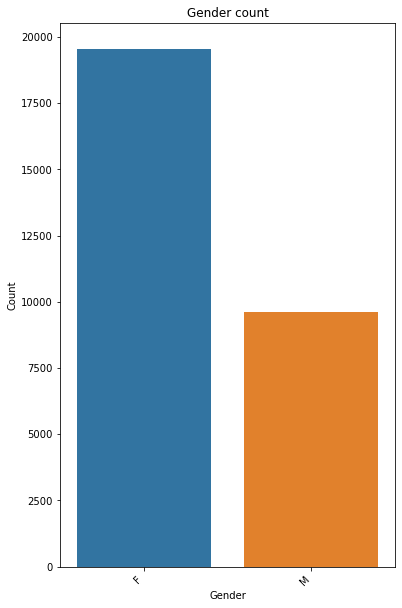

In [272]:
create_bar_plot(cc_train_copy,'Gender')

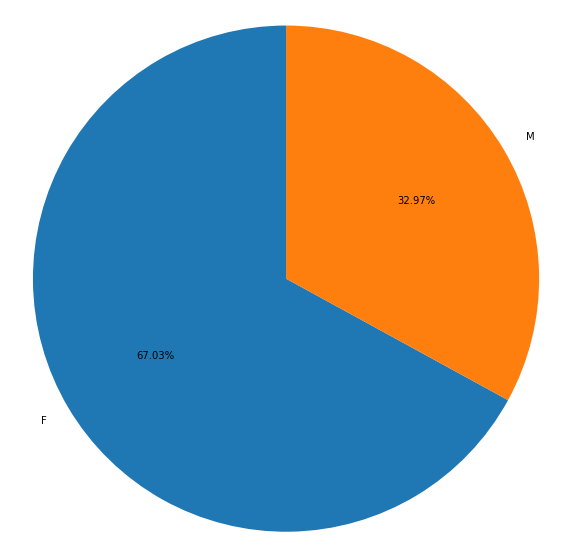

In [275]:
create_pie_plot(cc_train_copy,'Gender')

## 2. Age

In [293]:
gen_info_feat(cc_train_copy,'Age in days')

Description:
count   29165.00
mean       43.75
std        11.51
min        21.10
25%        34.15
50%        42.61
75%        53.23
max        68.86
Name: Age in days, dtype: float64
**************************************************
Object type:int64


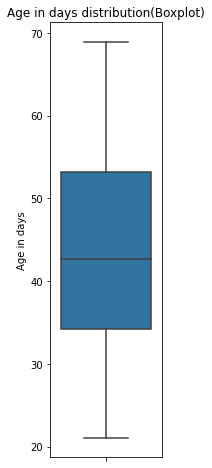

In [298]:
create_box_plot(cc_train_copy,'Age in days')

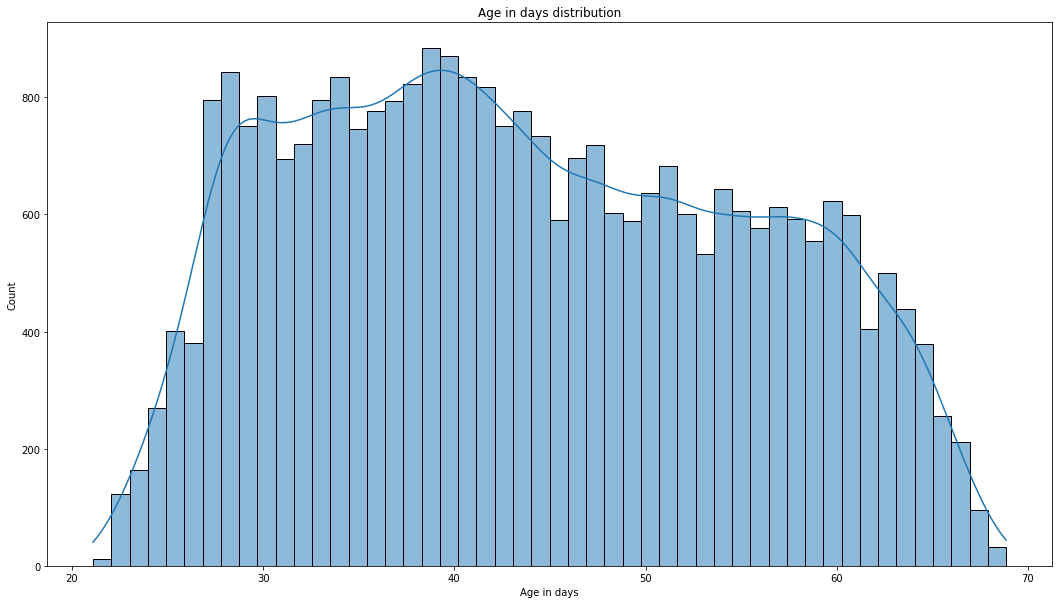

In [303]:
create_hist_plot(cc_train_copy,'Age in days')

Is high risk
0   43.75
1   43.54
Name: Age in days, dtype: float64


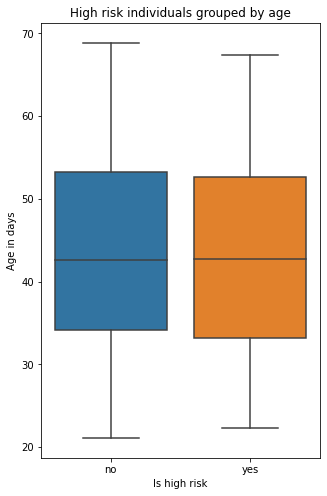

In [305]:
low_high_risk_box_plot(cc_train_copy,'Age in days')

## 3. Marital status

In [309]:
gen_info_feat(cc_train_copy,'Marital status')

Description:
count       29165
unique          5
top       Married
freq        20044
Name: Marital status, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                      Count  Frequency (%)
Married               20044          68.73
Single / not married   3864          13.25
Civil marriage         2312           7.93
Separated              1712           5.87
Widow                  1233           4.23


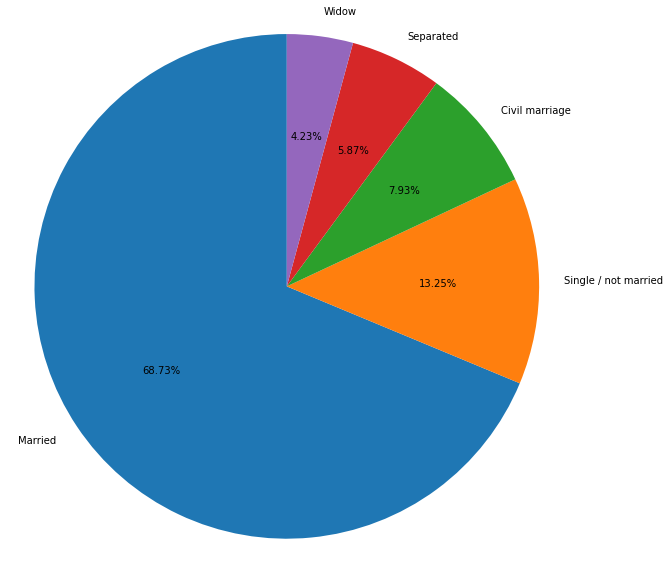

In [310]:
create_pie_plot(cc_train_copy,'Marital status')

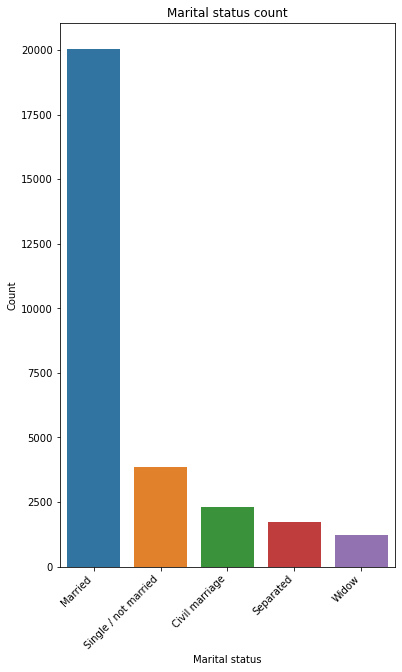

In [311]:
create_bar_plot(cc_train_copy,'Marital status')

In [148]:
# High risk applicants grouped by their marital status
is_high_risk_ms_grp = cc_train_copy.groupby('Marital status')['Is high risk'].sum()

In [149]:
is_high_risk_ms_grp = is_high_risk_ms_grp.sort_values(ascending=False)
is_high_risk_ms_grp

Marital status
Married                 320
Single / not married     87
Civil marriage           34
Widow                    34
Separated                24
Name: Is high risk, dtype: object

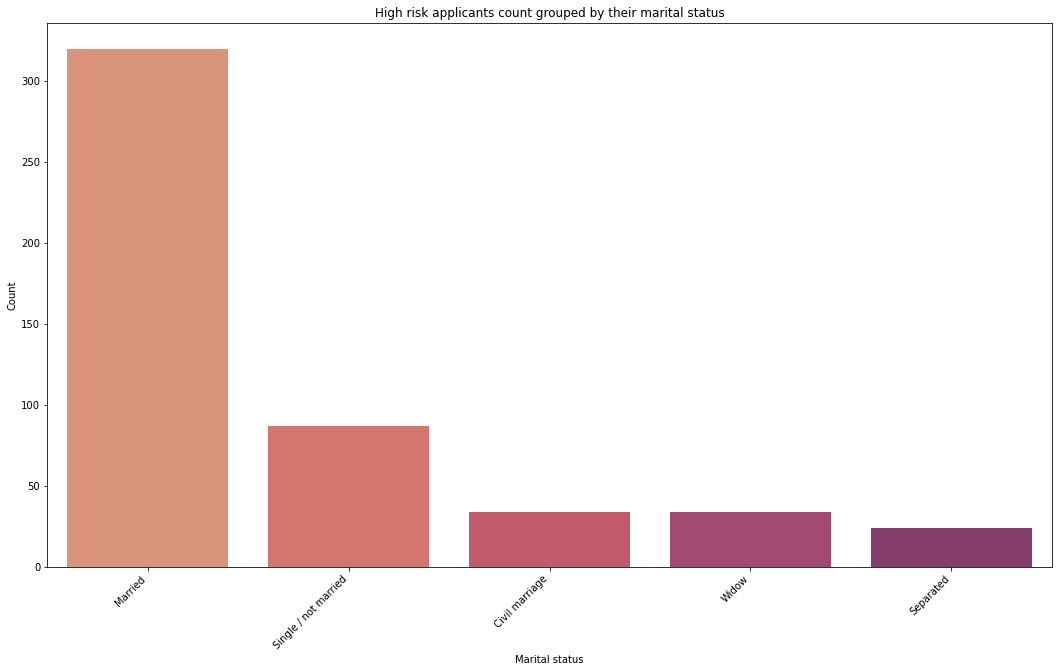

In [150]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=is_high_risk_ms_grp.index,y=is_high_risk_ms_grp.values,palette=sns.color_palette('flare'))
ax.set_xticklabels(labels=['Married','Single / not married','Civil marriage', 'Widow', 'Separated'],rotation=45, ha='right')
plt.ylabel('Count')
plt.title('High risk applicants count grouped by their marital status')
plt.show()

## 4. Family member count

In [151]:
cc_train_copy['Family member count'].describe()

count    29165.000000
mean         2.197531
std          0.912189
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         20.000000
Name: Family member count, dtype: float64

In [152]:
cc_train_copy['Family member count'].dtype

dtype('float64')

In [153]:
value_cnt_norm_cal(cc_train_copy, 'Family member count')

,Count,Frequency (%)
2.0,15552,53.324190
1.0,5613,19.245671
3.0,5121,17.558718
4.0,2503,8.582205
5.0,309,1.059489
6.0,48,0.164581
7.0,14,0.048003
9.0,2,0.006858
15.0,2,0.006858
20.0,1,0.003429


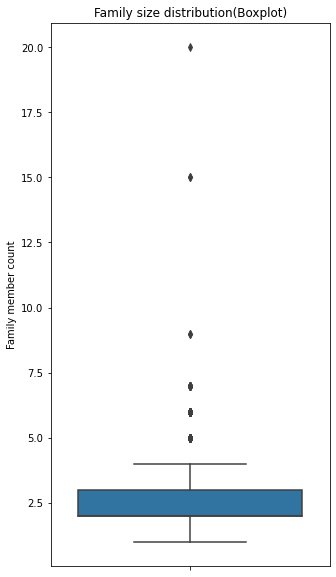

In [154]:
fig, ax = plt.subplots(figsize=(5,10))
sns.boxplot(y=cc_train_copy['Family member count'])
plt.title('Family size distribution(Boxplot)')
plt.show()

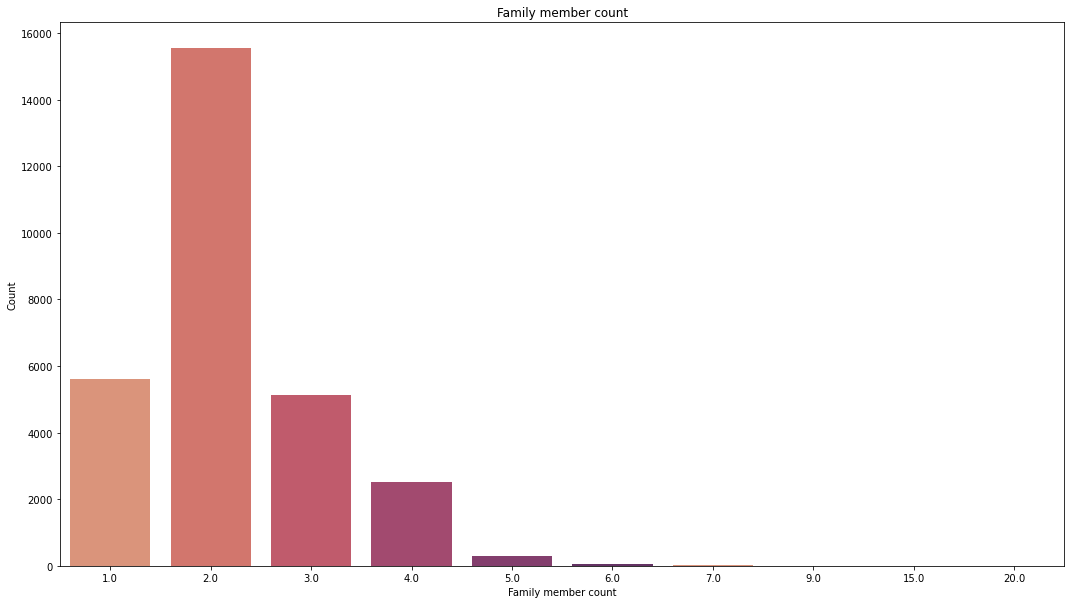

In [155]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=cc_train_copy['Family member count'].value_counts().index,y=cc_train_copy['Family member count'].value_counts().values,palette=sns.color_palette('flare'))
plt.xlabel('Family member count')
plt.ylabel('Count')
plt.title('Family member count')
plt.show()

## 5. Children count

In [156]:
cc_train_copy['Children count'].describe()

count    29165.000000
mean         0.430790
std          0.741882
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         19.000000
Name: Children count, dtype: float64

In [157]:
cc_train_copy['Children count'].dtype

dtype('int64')

In [158]:
value_cnt_norm_cal(cc_train_copy, 'Children count')

,Count,Frequency (%)
0,20143,69.065661
1,6003,20.582890
2,2624,8.997086
3,323,1.107492
4,52,0.178296
5,15,0.051432
7,2,0.006858
14,2,0.006858
19,1,0.003429


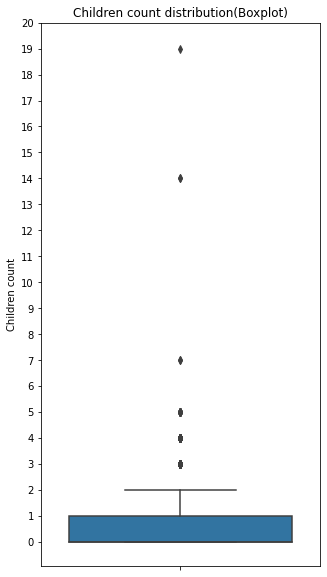

In [159]:
fig, ax = plt.subplots(figsize=(5,10))
sns.boxplot(y=cc_train_copy['Children count'])
plt.title('Children count distribution(Boxplot)')
plt.yticks(np.arange(0,21,1))
plt.show()

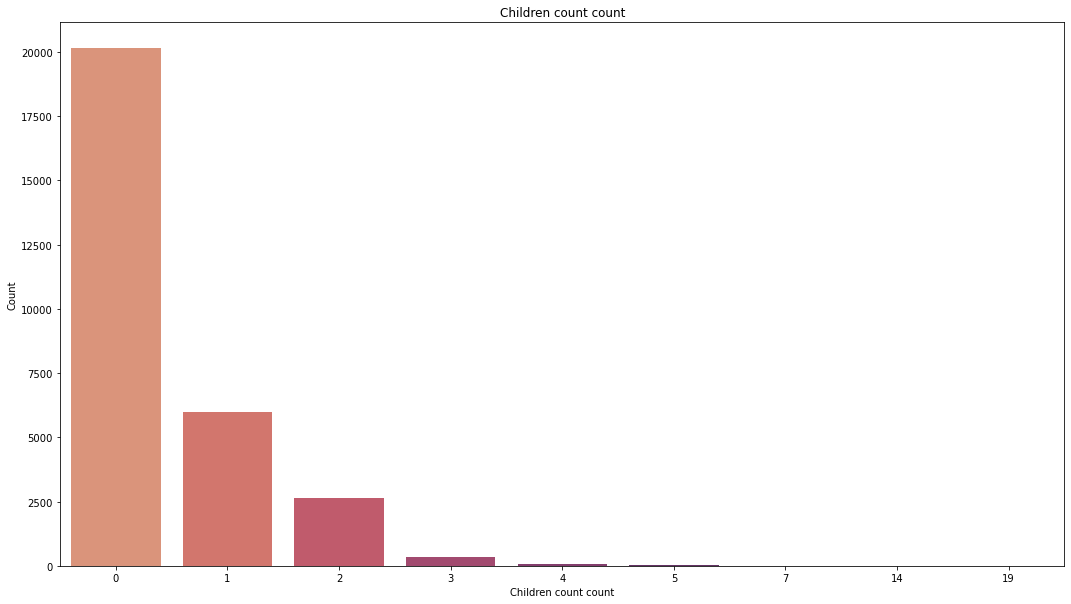

In [160]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=cc_train_copy['Children count'].value_counts().index,y=cc_train_copy['Children count'].value_counts().values,palette=sns.color_palette('flare'))
plt.xlabel('Children count count')
plt.ylabel('Count')
plt.title('Children count count')
plt.show()

## 6. Dwelling type

In [161]:
cc_train_copy['Dwelling'].describe()

count                 29165
unique                    6
top       House / apartment
freq                  26059
Name: Dwelling, dtype: object

In [162]:
cc_train_copy['Dwelling'].unique()

array(['With parents', 'House / apartment', 'Municipal apartment',
       'Rented apartment', 'Office apartment', 'Co-op apartment'],
      dtype=object)

In [163]:
cc_train_copy['Dwelling'].dtype

dtype('O')

In [164]:
value_cnt_norm_cal(cc_train_copy, 'Dwelling')

,Count,Frequency (%)
House / apartment,26059,89.350249
With parents,1406,4.820847
Municipal apartment,912,3.127036
Rented apartment,453,1.553232
Office apartment,208,0.713184
Co-op apartment,127,0.435453


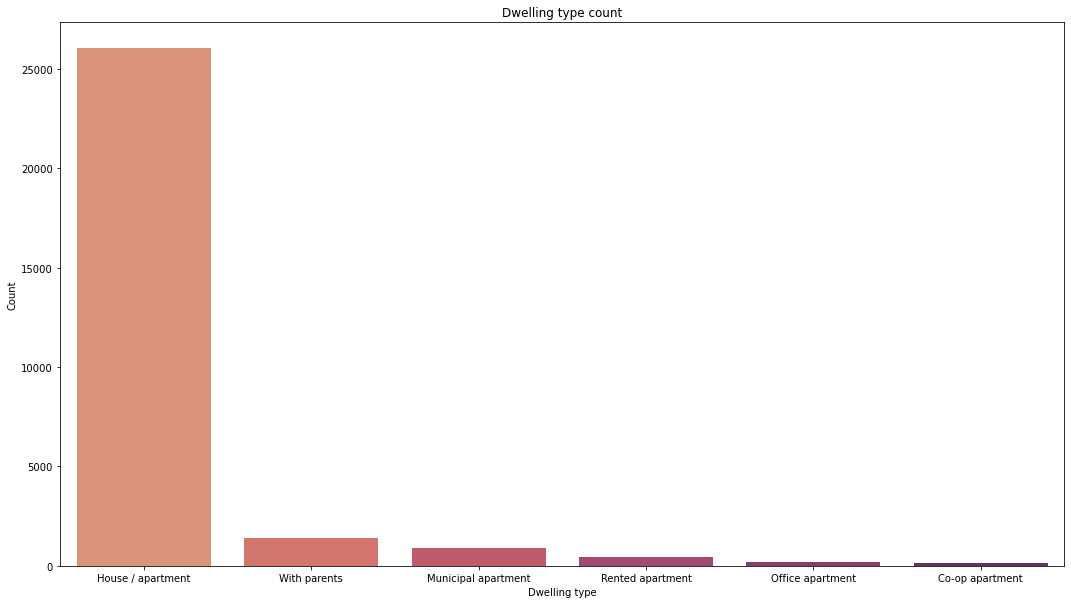

In [165]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=cc_train_copy['Dwelling'].value_counts().index,y=cc_train_copy['Dwelling'].value_counts().values,palette=sns.color_palette('flare'))
#ax.set_xticklabels(labels=['Married', 'Single / not married', 'Civil marriage','Separated', 'Widow'],rotation=45,ha='right')
plt.xlabel('Dwelling type')
plt.ylabel('Count')
plt.title('Dwelling type count')
plt.show()

In [166]:
dwelling_ratio_size = value_cnt_norm_cal(cc_train_copy, 'Dwelling')

In [167]:
dwelling_ratio_size

,Count,Frequency (%)
House / apartment,26059,89.350249
With parents,1406,4.820847
Municipal apartment,912,3.127036
Rented apartment,453,1.553232
Office apartment,208,0.713184
Co-op apartment,127,0.435453


In [168]:
dwelling_ratio = dwelling_ratio_size['Frequency (%)'].loc['House / apartment'], dwelling_ratio_size['Frequency (%)'].loc['With parents'], dwelling_ratio_size['Frequency (%)'].loc['Municipal apartment'], dwelling_ratio_size['Frequency (%)'].loc['Rented apartment'], dwelling_ratio_size['Frequency (%)'].loc['Office apartment'], dwelling_ratio_size['Frequency (%)'].loc['Co-op apartment']

In [169]:
dwelling_ratio

(89.35024858563347,
 4.820846905537459,
 3.1270358306188926,
 1.5532316132350419,
 0.7131836104920282,
 0.43545345448311334)

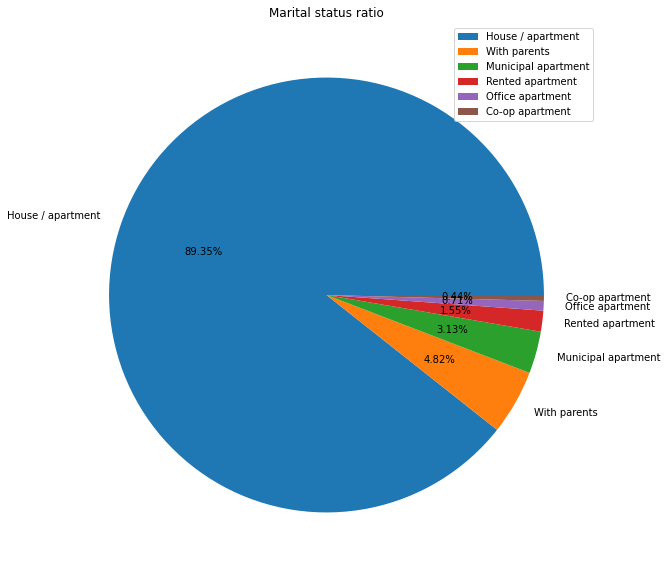

In [197]:
fig, ax = plt.subplots(figsize=(18,10))
plt.pie(dwelling_ratio,labels=['House / apartment','With parents','Municipal apartment','Rented apartment','Office apartment','Co-op apartment'],autopct='%1.2f%%')
plt.title('Marital status ratio')
plt.legend(loc='upper right')
plt.show()

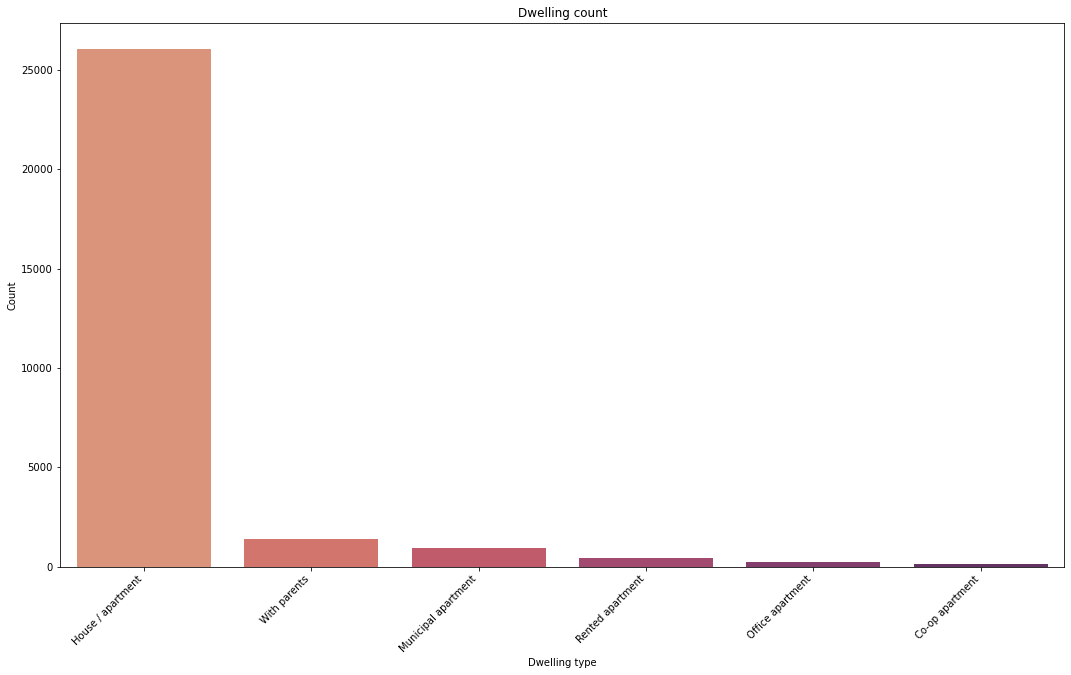

In [171]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=cc_train_copy['Dwelling'].value_counts().index,y=cc_train_copy['Dwelling'].value_counts().values,palette=sns.color_palette('flare'))
ax.set_xticklabels(labels=['House / apartment','With parents','Municipal apartment','Rented apartment','Office apartment','Co-op apartment'],rotation=45,ha='right')
plt.xlabel('Dwelling type')
plt.ylabel('Count')
plt.title('Dwelling count')
plt.show()

## 7. Income

In [172]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
cc_train_copy['Income'].describe()

count     29165.00
mean     186890.39
std      101409.64
min       27000.00
25%      121500.00
50%      157500.00
75%      225000.00
max     1575000.00
Name: Income, dtype: float64

In [173]:
cc_train_copy['Income'].dtype

dtype('float64')

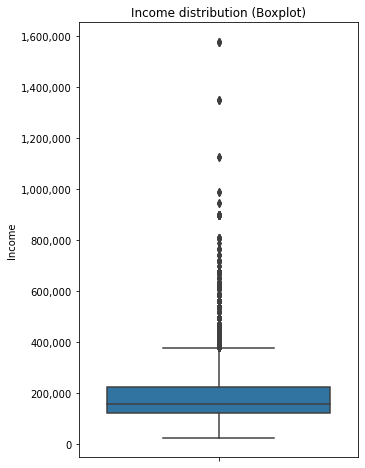

In [174]:
fig, ax = plt.subplots(figsize=(5,8))
sns.boxplot(y=cc_train_copy['Income'])
# suppress scientific notation
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.title('Income distribution (Boxplot)')
plt.show()

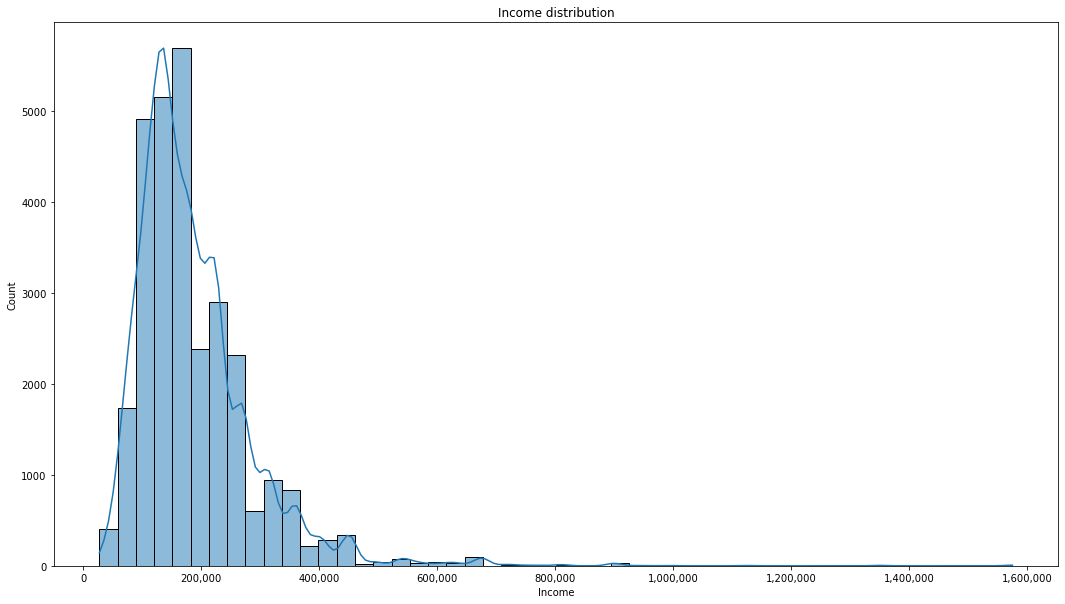

In [175]:
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(cc_train_copy['Income'],bins=50,kde=True)
# suppress scientific notation
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.title('Income distribution')
plt.show()

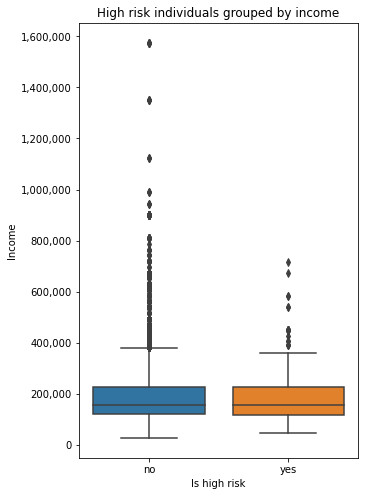

In [176]:
# High risk vs low risk applicants compared by their income
fig, ax = plt.subplots(figsize=(5,8))
sns.boxplot(y=cc_train_copy['Income'],x=cc_train_copy['Is high risk'])
# suppress scientific notation
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(ticks=[0,1],labels=['no','yes'])
plt.title('High risk individuals grouped by income')
plt.show()

## 8. Job title

In [177]:
cc_train_copy['Job title'].describe()

count        20138
unique          18
top       Laborers
freq          5004
Name: Job title, dtype: object

In [178]:
job_title_nan_count = cc_train_copy['Job title'].isna().sum()

In [179]:
rows_total_count = cc_train_copy.shape[0]

In [180]:
print('The percentage of missing rows is {:.2f} %'.format(job_title_nan_count * 100 / rows_total_count))

The percentage of missing rows is 30.95 %


In [181]:
cc_train_copy['Job title'].dtype

dtype('O')

In [182]:
value_cnt_norm_cal(cc_train_copy, 'Job title')

,Count,Frequency (%)
Laborers,5004,24.85
Core staff,2866,14.23
Sales staff,2773,13.77
Managers,2422,12.03
Drivers,1722,8.55
High skill tech staff,1133,5.63
Accountants,998,4.96
Medicine staff,956,4.75
Cooking staff,521,2.59
Security staff,464,2.30


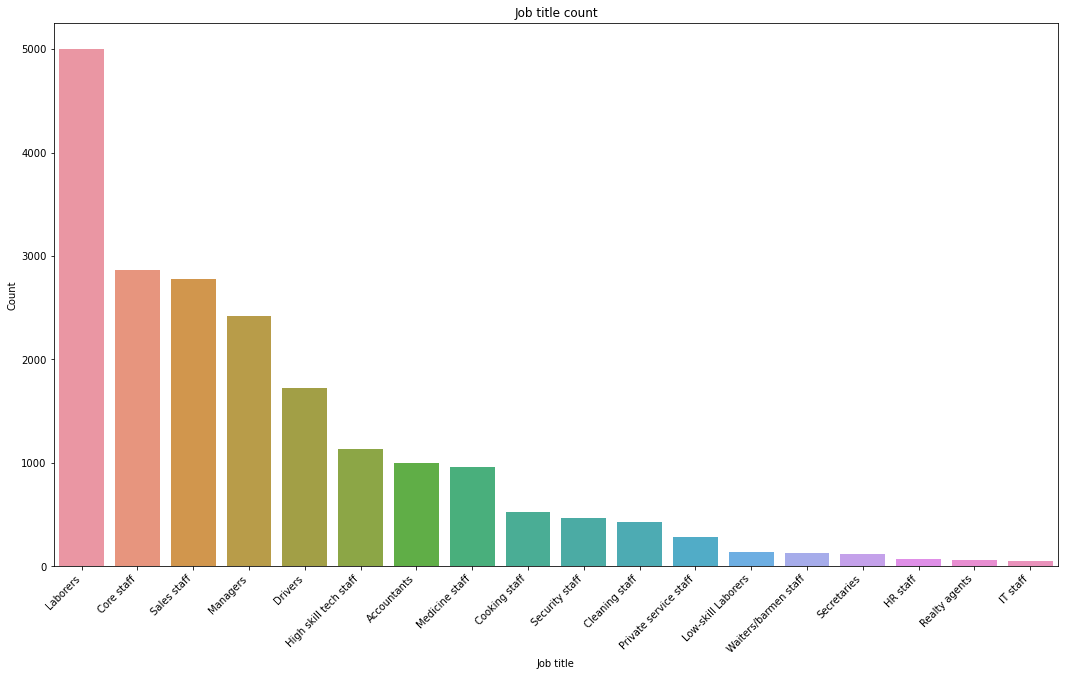

In [183]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=cc_train_copy['Job title'].value_counts().index,y=cc_train_copy['Job title'].value_counts().values)
ax.set_xticklabels(labels=['Laborers', 'Core staff', 'Sales staff', 'Managers', 'Drivers','High skill tech staff', 'Accountants', 'Medicine staff','Cooking staff', 'Security staff', 'Cleaning staff','Private service staff', 'Low-skill Laborers', 'Waiters/barmen staff','Secretaries', 'HR staff', 'Realty agents', 'IT staff'],rotation=45,ha='right')
plt.xlabel('Job title')
plt.ylabel('Count')
plt.title('Job title count')
plt.show()

## 9. Employment type

In [185]:
cc_train_copy['Employment type'].describe()

count       29165
unique          5
top       Working
freq        15056
Name: Employment type, dtype: object

In [186]:
cc_train_copy['Employment type'].unique()

array(['Working', 'Commercial associate', 'Pensioner', 'State servant',
       'Student'], dtype=object)

In [187]:
cc_train_copy['Employment type'].dtype

dtype('O')

In [188]:
value_cnt_norm_cal(cc_train_copy, 'Employment type')

,Count,Frequency (%)
Working,15056,51.62
Commercial associate,6801,23.32
Pensioner,4920,16.87
State servant,2381,8.16
Student,7,0.02


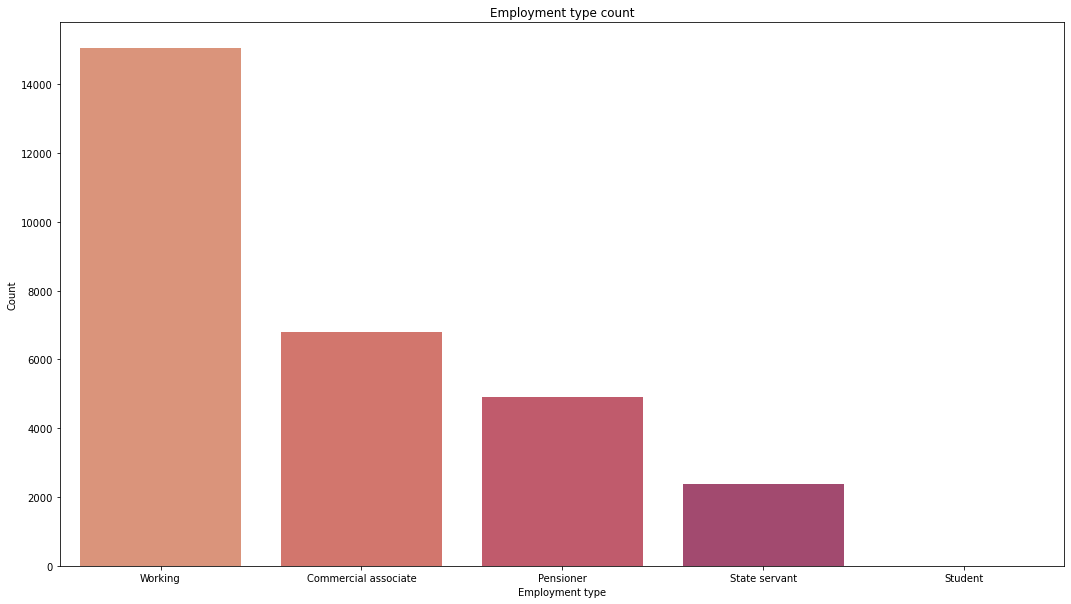

In [190]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=cc_train_copy['Employment type'].value_counts().index,y=cc_train_copy['Employment type'].value_counts().values,palette=sns.color_palette('flare'))
plt.xlabel('Employment type')
plt.ylabel('Count')
plt.title('Employment type count')
plt.show()

In [191]:
employment_ratio_size = value_cnt_norm_cal(cc_train_copy, 'Employment type')

In [192]:
employment_ratio_size

,Count,Frequency (%)
Working,15056,51.62
Commercial associate,6801,23.32
Pensioner,4920,16.87
State servant,2381,8.16
Student,7,0.02


In [193]:
employment_ratio = employment_ratio_size['Frequency (%)'].loc['Working'], employment_ratio_size['Frequency (%)'].loc['Commercial associate'], employment_ratio_size['Frequency (%)'].loc['Pensioner'], employment_ratio_size['Frequency (%)'].loc['State servant'], employment_ratio_size['Frequency (%)'].loc['Student']

In [194]:
employment_ratio

(51.623521344076806,
 23.31904680267444,
 16.869535402022972,
 8.163895079718841,
 0.024001371506943252)

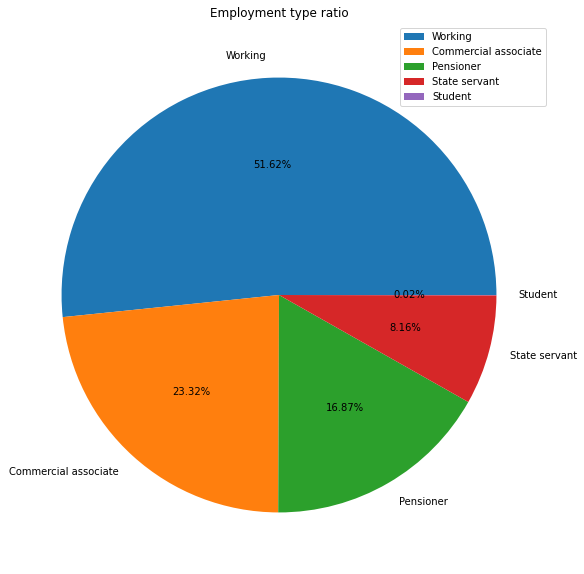

In [196]:
fig, ax = plt.subplots(figsize=(18,10))
plt.pie(employment_ratio,labels=['Working','Commercial associate','Pensioner','State servant','Student'],autopct='%1.2f%%')
plt.title('Employment type ratio')
plt.legend(loc='upper right')
plt.show()

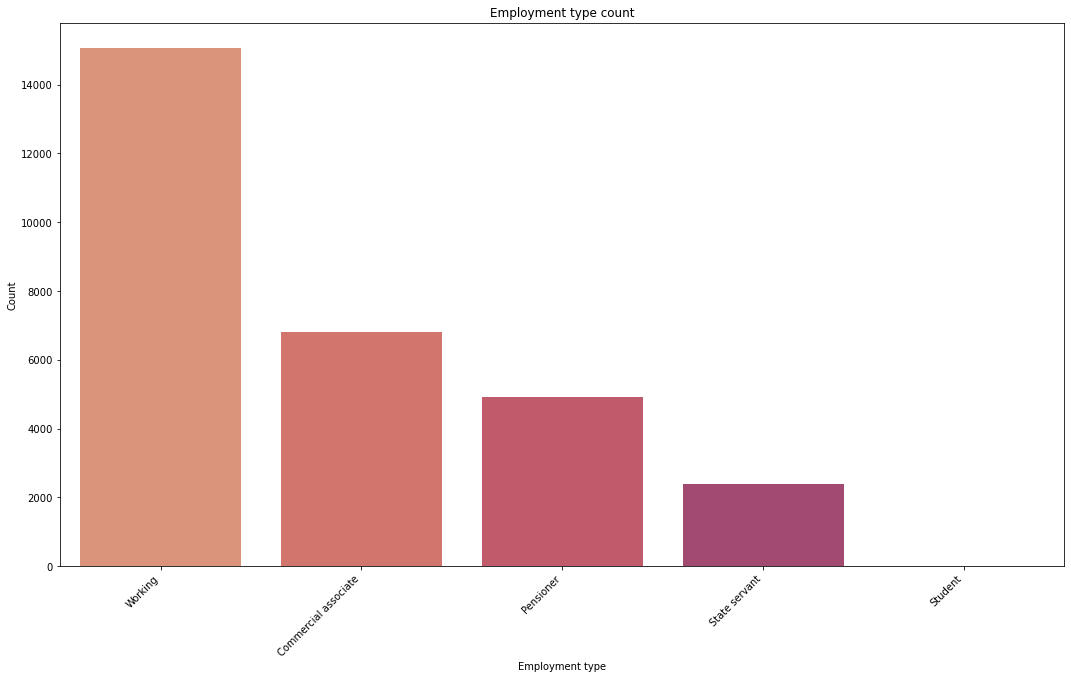

In [205]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=cc_train_copy['Employment type'].value_counts().index,y=cc_train_copy['Employment type'].value_counts().values,palette=sns.color_palette('flare'))
ax.set_xticklabels(labels=['Working','Commercial associate','Pensioner','State servant','Student'],rotation=45,ha='right')
plt.xlabel('Employment type')
plt.ylabel('Count')
plt.title('Employment type count')
plt.show()

## 10. Education level

In [214]:
cc_train_copy['Education level'].describe()

count                             29165
unique                                5
top       Secondary / secondary special
freq                              19803
Name: Education level, dtype: object

In [215]:
cc_train_copy['Education level'].unique()

array(['Secondary / secondary special', 'Higher education',
       'Lower secondary', 'Incomplete higher', 'Academic degree'],
      dtype=object)

In [216]:
cc_train_copy['Education level'].dtype

dtype('O')

In [217]:
value_cnt_norm_cal(cc_train_copy, 'Education level')

,Count,Frequency (%)
Secondary / secondary special,19803,67.90
Higher education,7910,27.12
Incomplete higher,1129,3.87
Lower secondary,298,1.02
Academic degree,25,0.09


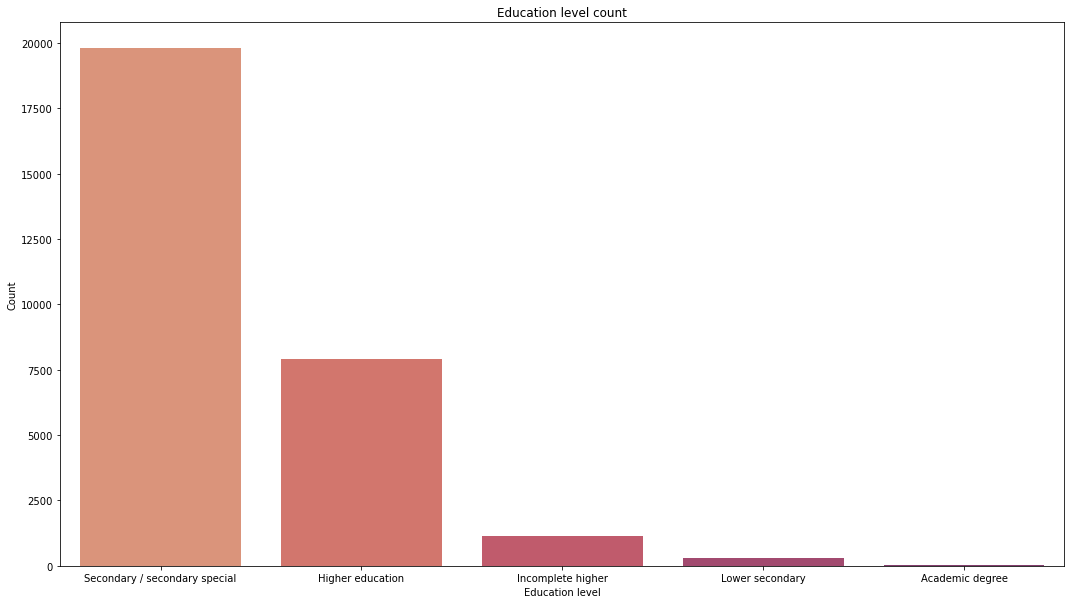

In [218]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=cc_train_copy['Education level'].value_counts().index,y=cc_train_copy['Education level'].value_counts().values,palette=sns.color_palette('flare'))
plt.xlabel('Education level')
plt.ylabel('Count')
plt.title('Education level count')
plt.show()

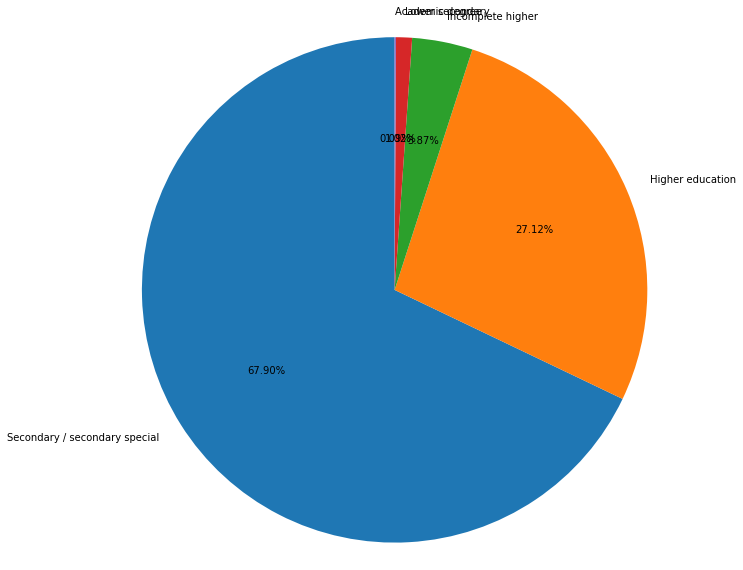

In [247]:
create_pie_plot(cc_train_copy, 'Education level')

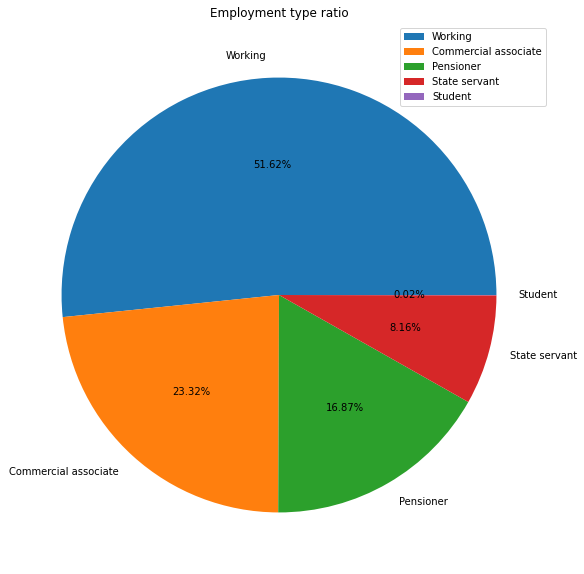

In [ ]:
fig, ax = plt.subplots(figsize=(18,10))
plt.pie(employment_ratio,labels=['Working','Commercial associate','Pensioner','State servant','Student'],autopct='%1.2f%%')
plt.title('Employment type ratio')
plt.legend(loc='upper right')
plt.show()

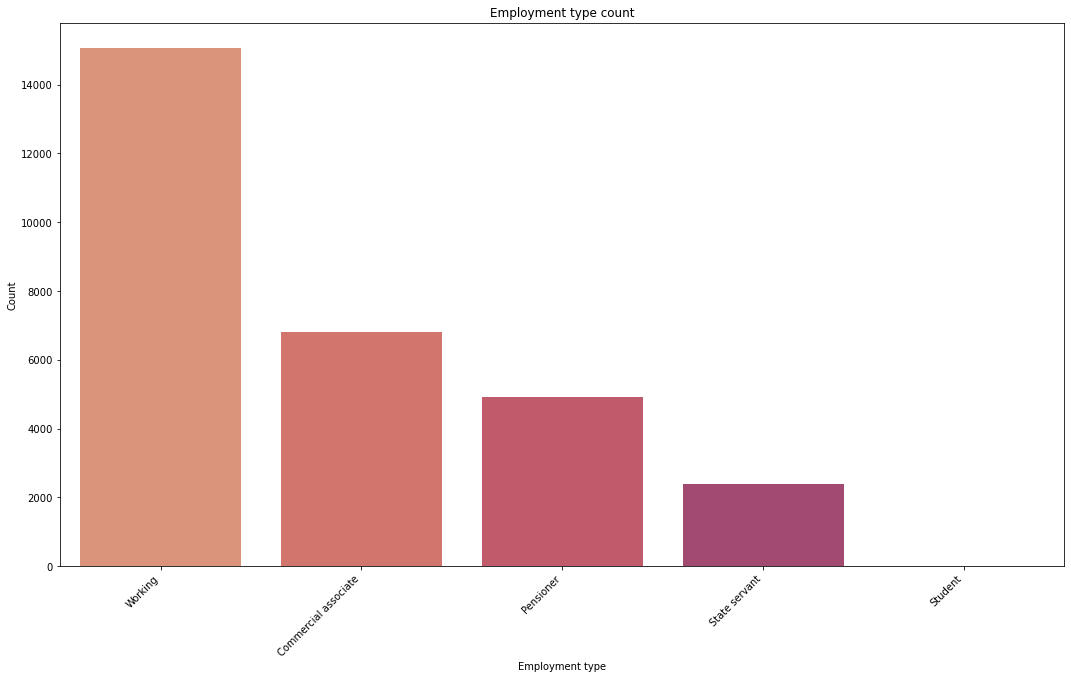

In [245]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=cc_train_copy['Employment type'].value_counts().index,y=cc_train_copy['Employment type'].value_counts().values,palette=sns.color_palette('flare'))
ax.set_xticklabels(labels=['Working','Commercial associate','Pensioner','State servant','Student'],rotation=45,ha='right')
plt.xlabel('Employment type')
plt.ylabel('Count')
plt.title('Employment type count')
plt.show()

In [206]:
cc_train_copy['Education level'].describe()

count                             29165
unique                                5
top       Secondary / secondary special
freq                              19803
Name: Education level, dtype: object

In [207]:
cc_train_copy['Education level'].unique()

array(['Secondary / secondary special', 'Higher education',
       'Lower secondary', 'Incomplete higher', 'Academic degree'],
      dtype=object)

In [ ]:
application_train_copy['Education level'].value_counts()

In [ ]:
fig, ax = plt.subplots()
sns.barplot(x=application_train_copy['Education level'].value_counts().index,y=application_train_copy['Education level'].value_counts().values,palette=sns.color_palette('flare'))
ax.set_xticklabels(labels=application_train_copy['Education level'].value_counts().index.to_list(),rotation=45,ha='right')
plt.xlabel('Education level')
plt.ylabel('Count')
plt.title('Education level distribution')
plt.show()

#### 11. Days since employment (positive means unemployed)

In [ ]:
application_train_copy['Days since employment (positive means unemployed)'].describe()

#### Days since employment distribution

In [ ]:
sns.histplot(data=application_train_copy['Days since employment (positive means unemployed)'],bins=50,kde=True)
plt.title('Days since employment distribution')
plt.show()

In [ ]:
days_since_employment_no_ret = application_train_copy['Days since employment (positive means unemployed)'][application_train_copy['Days since employment (positive means unemployed)'] != 365243]

In [ ]:
sns.histplot(data=days_since_employment_no_ret,bins=50,kde=True)
plt.title('Days since employment distribution (retirement not accounted)')
plt.show()

In [ ]:
sns.boxplot(y=days_since_employment_no_ret)
plt.show()

#### 12. Has a car

In [ ]:
application_train_copy['Has a car'].describe()

In [ ]:
application_train_copy['Has a car'].value_counts()

In [ ]:
application_train_copy['Has a car'].value_counts(normalize=True) * 100

#### Car ownership ratio

In [ ]:
size_car_own = application_train_copy['Has a car'].value_counts().values
size_car_own

In [ ]:
plt.pie(size_car_own,labels=['Does not own a car','Own a car'],autopct='%1.0f%%')
plt.title('Car owner ratio')
plt.show()

#### Car ownership count

In [ ]:
sns.barplot(x=application_train_copy['Has a car'].value_counts().index,y=size_car_own)
plt.xlabel('Have a car')
plt.ylabel('Count')
plt.title('Car owner count')
plt.show()

#### 13. Has a property

In [ ]:
application_train_copy['Has a property'].describe()

In [ ]:
application_train_copy['Has a property'].value_counts()

In [ ]:
application_train_copy['Has a property'].value_counts(normalize=True) * 100

#### Property ownership ratio

In [ ]:
size_prop_own = application_train_copy['Has a property'].value_counts().values
size_prop_own

In [ ]:
plt.pie(size_prop_own,labels=['Own a property', 'Does not own a property'],autopct='%1.0f%%')
plt.title('Property owner ratio')
plt.show()

#### Property ownership count

In [ ]:
sns.barplot(x=application_train_copy['Has a property'].value_counts().index,y=size_prop_own)
plt.xlabel('Have a property')
plt.ylabel('Count')
plt.title('Property owner count')
plt.show()

#### 14. Has a work phone

In [ ]:
application_train_copy['Has a work phone'].describe()

In [ ]:
application_train_copy['Has a work phone'].value_counts()

In [ ]:
application_train_copy['Has a work phone'].value_counts(normalize=True) * 100

#### Work phone ownership ratio

In [ ]:
size_work_phone = application_train_copy['Has a work phone'].value_counts().values
size_work_phone

In [ ]:
plt.pie(size_work_phone,labels=['Does not own a work phone','Own a work phone'],autopct='%1.0f%%')
plt.title('Work phone owner ratio')
plt.show()

#### Work phone  ownership count

In [ ]:
sns.barplot(x=application_train_copy['Has a work phone'].value_counts().index,y=size_work_phone)
plt.xlabel('Has a work phone')
plt.ylabel('Count')
plt.title('Work phone owner count')
plt.show()

#### 15. Has a mobile phone

In [ ]:
application_train_copy['Has a mobile phone']

In [ ]:
application_train_copy['Has a mobile phone'].unique()

In [ ]:
application_train_copy['Has a mobile phone'].value_counts()

In [ ]:
size_mobile_own = application_train_copy['Has a mobile phone'].value_counts().values
size_mobile_own
plt.pie(size_mobile_own,labels=['Own a mobile phone'],autopct='%1.0f%%')
plt.title('Mobile owner ratio')
plt.show()

#### 16. Has a phone

In [ ]:
application_train_copy['Has a phone'].value_counts(normalize=True) * 100

#### Phone ownership ratio

In [ ]:
size_phone_own = application_train_copy['Has a phone'].value_counts().values
size_phone_own

In [ ]:
plt.pie(size_phone_own,labels=['Does not own a phone','Own a phone'],autopct='%1.0f%%')
plt.title('Phone owner ratio')
plt.show()

#### Phone ownership count

In [ ]:
sns.barplot(x=application_train_copy['Has a phone'].value_counts().index,y=size_phone_own)
plt.xlabel('Has a phone')
plt.ylabel('Count')
plt.title('Phone owner count')
plt.show()

#### 17. Has an email

In [ ]:
application_train_copy['Has an email'].value_counts()

In [ ]:
application_train_copy['Has an email'].value_counts()

In [ ]:
application_train_copy['Has an email'].value_counts(normalize=True) * 100

#### Email ownership ratio

In [ ]:
size_email_own = application_train_copy['Has an email'].value_counts().values
size_email_own

In [ ]:
plt.pie(size_email_own,labels=['Does not have an email','Have an email'],autopct='%1.0f%%')
plt.title('Email owner ratio')
plt.show()

#### Email ownership count

In [ ]:
sns.barplot(x=application_train_copy['Has an email'].value_counts().index,y=size_email_own)
plt.xlabel('Has an email')
plt.ylabel('Count')
plt.title('Car owner count')
plt.show()

#### 4. For supervised learning tasks, identify the target attribute(s).

The target 'Is high risk'

#### Target analysis

In [ ]:
high_risk_count = application_train_copy['Is high risk'].value_counts()
high_risk_count 

In [ ]:
high_risk_ratio = application_train_copy['Is high risk'].value_counts(normalize=True) * 100
high_risk_ratio 

In [ ]:
plt.pie(high_risk_ratio,labels=['No','Yes'],autopct='%1.0f%%')
plt.title('High risk ratio')
plt.show()

In [ ]:
fig, ax = plt.subplots()
sns.barplot(x=high_risk_count.index,y=high_risk_count.values)
ax.set_xticklabels(['No','Yes'])
plt.xlabel('High risk')
plt.ylabel('Count')
plt.title('High risk count')
plt.show()

#### 5. Visualize the correlation within the data.

In [ ]:
sns.pairplot(application_train_copy[['Days since birth','Family size','Children count','Income','Days since employment (positive means unemployed)','Is high risk']],corner=True)
plt.show()

In [ ]:
app_corr_matrix = application_train_copy.corr()
app_corr_matrix

In [ ]:
mask = np.zeros_like(app_corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True
app_corr_matrix[mask] = np.nan
(app_corr_matrix
 .style
 .background_gradient(cmap='bwr', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  
)

#### 6. Study the correlations between attributes.

#### 6.1 Family size vs Children count

In [ ]:
sns.regplot(x=application_train_copy['Family size'],y=application_train_copy['Children count'],line_kws={'color': 'red'})
plt.show()

#### Days since birth vs Days since employment

In [ ]:
sns.scatterplot(x=application_train_copy['Days since employment (positive means unemployed)'][application_train_copy['Days since employment (positive means unemployed)'] != 365243],y=application_train_copy['Days since birth'],alpha=.1)
plt.show()

#### 7. Study how you would solve the problem manually.

Consult expert subject matter in credit scoring

#### 8. Identify the promising transformations you may want to apply.

Transformation to do:

    - Encoding: Label encoding for sex
    - Encoding: Label encoding for Marital Status
    - Encoding: Label encoding for Way of living
    - Encoding: Label encoding for Occupation
    - Encoding: Label encoding for Has a car
    - Encoding: Label encoding for Has a property
    - Encoding: Label encoding for Income Category
    - Encoding: Label encoding for Education
    
    - Custom Transformation: Detect and remove outliers
    - Custom Transformation: Remove missing data
    - Custom Transformation: Balance the data in pipeline
    - Custom Transformation: Change to absolute value and divide the Days since birth by 365.25
    - Custom Transformation: Change name Days since birth to Age
    - Custom Transformation: Change to absolute value and divide the Days since employment by 365.25
    - Custom Transformation: Change name Days since employment to Experience length
    - Custom Transformation: Drop has mobile phone
    - Customer Transformation: Balance the skewed data income column, age, experience length
   
        ** Toggle and check with model perfomance
    - Custom Transformation: Keep Family size and drop Children count 
    - Custom Transformation: Keep Children count and drop Family size
    - Custom Transformation: Keep/drop the occupation column
    - Custom Transformation: Use Days of employment as part of the outliers column
    
    
    - Scalling: Min-max for Age
    - Scalling: Min-max for income
    - Scalling: Min-max for Experience   
    
    
    - Imputation: Impute Occupation
   
    - Oversample with SMOTE after encoding before modelling  

#### 9. Identify extra data that would be useful (go back to “Get the Data”).

Not applicable

#### 10. Document what you have learned.

Refer to the report

### Prepare the Data

#### 1. Data Cleaning

#### 1.1 Custom transformer to handle outliers

In [ ]:
class OutlierExtractor(BaseEstimator, TransformerMixin):
    def __init__(self,add_days_employed_to_col=False,outlier_col = ['Family size','Children count','Income']):
        self.outlier_col = outlier_col
        self.add_days_employed_to_col = add_days_employed_to_col
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        outlier_col = []
        def outlier_cal(outlier_col):
            Q1 = X[self.outlier_col].quantile(.25)
            Q3 = X[self.outlier_col].quantile(.75)
            IQR = Q3 - Q1
            outlier_condition = (X[self.outlier_col] < (Q1 - 1.5 * IQR)) | (X[self.outlier_col] > (Q3 + 1.5 * IQR))
            index_to_keep = X[~outlier_condition.any(axis=1)].index
            return X.loc[index_to_keep]
        if self.add_days_employed_to_col:
            self.outlier_col.append('Days since employment (positive means unemployed)')
            return outlier_cal(self.outlier_col)
        else:
            if len(self.outlier_col) == 3:
                return outlier_cal(self.outlier_col)
            else:
                self.outlier_col.remove('Days since employment (positive means unemployed)')
                return outlier_cal(self.outlier_col)

In [ ]:
outlier_remover = OutlierExtractor()

#### 1.2 Custom transformer to handle missing value

In [ ]:
application_train_copy[application_train_copy['Days since employment (positive means unemployed)'] == 365243]['Occupation']

In [ ]:
application_train['Occupation'].value_counts()

In [ ]:
class MissingValHandler(BaseEstimator, TransformerMixin):
    def __init__(self,drop_occupation=False):
        self.drop_occupation = drop_occupation
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if self.drop_occupation:
            X_no_occ = X.drop('Occupation',axis=1)
            return X_no_occ
        else:
            nan_pensioner = X[X['Days since employment (positive means unemployed)'] == 365243]['Occupation']
            nan_pensioner_idx = X.loc[nan_pensioner.index.to_list()]['Occupation'].index.to_list()
            X.at[nan_pensioner_idx,'Occupation'] = 'Retired'
            #rest of nan other than the ones related to the retiment situation
            rest_nan_idx = X['Occupation'][X['Occupation'].isna()].index.to_list()
            most_freq_occ = X['Occupation'].value_counts().index[0]
            X['Occupation'].loc[rest_nan_idx] = most_freq_occ
            return X

#### 2. Feature selection

In [ ]:
application_train_copy = application_train.copy()

In [ ]:
class ColumnsToDrop(BaseEstimator,TransformerMixin):
    def __init__(self,column_to_drop = []):
        self.column_to_drop = column_to_drop
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if (set(self.column_to_drop).issubset(X.columns)):
                self.column_to_drop.append('Has a mobile phone')
                X.drop(self.column_to_drop,axis=1,inplace=True)
                return X
        else:
            if (set('Has a mobile phone').issubset(X.columns)):
                X.drop('Has a mobile phone',axis=1,inplace=True)
                return X
            else:
                return X

In [ ]:
feat_selector = ColumnsToDrop()

#### 3. Feature engineering

#### 3.1 Days transformation

In [ ]:
class DaysTransformation(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.days_col = ['Days since birth','Days since employment (positive means unemployed)']
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if (set(self.days_col).issubset(X.columns)):
            for col in self.days_col:
                if col == 'Days since birth':
                    X['Age'] = np.abs(X[col])/365.25
                    X.drop(col,axis=1,inplace=True)
                elif col == 'Days since employment (positive means unemployed)':
                    X[col] = np.abs(X[col])/365.25
                    X[X[col] == 999.980][col] = -1
                    X['Employment lenght (in years)'] = X[col]
                    X.drop(col,axis=1,inplace=True)
            return X
        else:
            return X

In [ ]:
day_col_est = DaysTransformation()

#### 3.2 Family children column drop

In [ ]:
class FamilyChildrenColToggle(BaseEstimator,TransformerMixin):
    def __init__(self, drop_family_col = False, drop_child_col = False):
        self.drop_family_col = drop_family_col
        self.drop_child_col = drop_child_col
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if self.drop_family_col & ('Family size' in X.columns):
            X.drop('Family size',axis=1,inplace=True) 
            return X 
        elif self.drop_child_col & ('Children count' in X.columns):
            X.drop('Children count',axis=1,inplace=True) 
            return X
        else:
            return X        

#### 3.3 Oversampling with SMOTE

In [ ]:
class OversampleSMOTE(BaseEstimator,TransformerMixin):
    def __init__(self, perform_oversampling = True):
        self.perform_oversampling = perform_oversampling
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if self.perform_oversampling:
            smote = SMOTE()
            X_bal, y_bal = smote.fit_resample(X[:,:-1],X[:,-1])
            X_y_bal = np.concatenate((X_bal,y_bal[:,None]),axis=1)
            return X_y_bal

        else:
            return X

#### 3.4 Target transformation column 

In [ ]:
class TargetColTransformation(BaseEstimator,TransformerMixin):
    def __init__(self,target_pos_change = False,target_drop = False):
        self.target_pos_change = target_pos_change
        self.target_drop = target_drop
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if self.target_drop:
            if self.target_pos_change == False:
                X_col_list = X.columns.to_list()
                X_col_list.remove('Is high risk')
                X = X[X_col_list]
                return X
            else:
                print('Cant change the position of the target while it was dropped')
                return X
        else:
            if self.target_pos_change:
                X_col_list = X.columns.to_list()
                X_col_list.remove('Is high risk')
                X_col_list.append('Is high risk')
                X = X[X_col_list]
                return X
            else:
                return X

#### 4. Feature scaling

Implemented with Column Transformer, but we will create a feature selector for selection the column to be scaled

#### 5. Put everything together in a column transformer/pipeline

In [ ]:
application_train_copy = application_train.copy()
application_test_copy = application_test.copy()

In [ ]:
def full_pipeline(df,type_dataframe):
    #columns to use in the column transformer
    enc_columns = ['Sex','Marital status','Way of living','Occupation','Has a car','Has a property','Income category','Education level']
    scale_columns = ['Age','Income','Employment lenght (in years)']

    #pipeline 
    if type_dataframe == 'Train':
        pipeline = Pipeline([
        ('imputer_missing',MissingValHandler()), #Has toggle option
         ('outlier',OutlierExtractor()), #Has toggle option
         ('feat_select',ColumnsToDrop()), #Has toggle option
         ('day_trans',DaysTransformation()),
         ('family_chil_trans',FamilyChildrenColToggle()), #Has toggle option
         ('y_trans',TargetColTransformation(target_pos_change = True))
        ])
        #Column transformer
        col_transformer = ColumnTransformer([
         ('encoder',OrdinalEncoder(),enc_columns),
         ('scaler',MinMaxScaler(),scale_columns),], remainder='passthrough')

    #     #pipeline for SMOTE
        pipeline_smote = Pipeline([
         ('smote',OversampleSMOTE())
         ])
    elif type_dataframe == 'Test':
        pipeline = Pipeline([
        ('imputer_missing',MissingValHandler()), #Has toggle option
        ('outlier',OutlierExtractor()), #Has toggle option
        ('feat_select',ColumnsToDrop()), #Has toggle option
        ('day_trans',DaysTransformation()),
        ('family_chil_trans',FamilyChildrenColToggle()), #Has toggle option
        # drop the target to avoid data snooping
        ('y_trans',TargetColTransformation(target_drop=True))
        ])
              #Column transformer
        col_transformer = ColumnTransformer([
        ('encoder',OrdinalEncoder(),enc_columns),
        ('scaler',MinMaxScaler(),scale_columns),], remainder='passthrough')

        #pipeline for SMOTE
        pipeline_smote = Pipeline([
        ('smote',OversampleSMOTE())
        ])

    
    
    if type_dataframe == 'Train':
        df_pip = pipeline.fit_transform(df)
        df_prepared = col_transformer.fit_transform(df_pip)
        df_bal = pipeline_smote.fit_transform(df_prepared)
        X_prep = df_bal[:,:-1]
        y_prep = df_bal[:,-1]
        return X_prep, y_prep
    # ToDo: Finish the test 
    elif type_dataframe == 'Test':
        df_pip = pipeline.transform(df)
        print(df_pip.columns)
        df_prepared = col_transformer.transform(df_pip)
        print(df_prepared.shape)
#         df_bal = pipeline_smote.transform(df_prepared)
#         print(df_bal.shape)
    else:
        print('Please select 'Train' or 'Test' for type_dataframe')

In [ ]:
X_train_prep, y_train_prep = full_pipeline(application_train_copy, 'Train')

In [ ]:
X_train_prep.shape

In [ ]:
y_train_prep.shape

### Shortlist Promising Models

In [ ]:
def fit_evaluate_model(model,X_train_prep,y_train_prep,cross_val = False):
    
    if cross_val:
        score_list = ['precision','recall','f1','accuracy','roc_auc']
        for score in score_list:
            scores = cross_val_score(model,X_train_prep,y_train_prep,scoring=score,cv=10)
            print('\n                        {} Score\n'.format(score))
            print('All the scores: {}'.format(scores))
            print('Mean of the scores: {}'.format(scores.mean()))
            print('Standard deviation: {}'.format(scores.std()))
            print('\n*****************************************************\n')
        
    else:
        model.fit(X_train_prep, y_train_prep)
        y_train_prediction = model.predict(X_train_prep)

        print('                        Classification Report')
        print(classification_report(y_train_prep,y_train_prediction))
        print('*****************************************************')

        print('Accuracy score {}'.format(accuracy_score(y_train_prep,y_train_prediction)))
        print('Confusion Matrix')
        plot_confusion_matrix(model,X_train_prep,y_train_prep)
        plt.show()
        print('*****************************************************')

        no_risk_probs = [0 for _ in range(len(y_train_prep))]
        risk_probs = model.predict_proba(X_train_prep)
        risk_probs_pos_outcome = risk_probs[:,1]
        no_risk_auc = roc_auc_score(y_train_prep,no_risk_probs)
        risk_auc = roc_auc_score(y_train_prep,risk_probs_pos_outcome)
        print('No risk: ROC AUC=%.3f' % (no_risk_auc))
        print('High risk: ROC AUC=%.3f' % (risk_auc))
        no_risk_false_pos_rate, no_risk_true_pos_rate, _ = roc_curve(y_train_prep,no_risk_probs)
        risk_false_pos_rate, risk_true_pos_rate, _ = roc_curve(y_train_prep,risk_probs_pos_outcome)
        plt.plot(no_risk_false_pos_rate, no_risk_true_pos_rate, linestyle='--', label='No risk')
        plt.plot(risk_false_pos_rate, risk_true_pos_rate, marker='.', label='High risk')
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        # show the legend
        plt.legend()
        # show the plot
        plt.show()

#### 1. Quick models comparison

#### 1.1 Logistic Regression

In [ ]:
log_reg = LogisticRegression(max_iter=1000)

In [ ]:
fit_evaluate_model(log_reg,X_train_prep,y_train_prep)
warnings.filterwarnings('ignore', category=DeprecationWarning) 

#### 1.2. Support Vector Machines

In [ ]:
svc_model = SVC(probability=True)

In [ ]:
fit_evaluate_model(svc_model,X_train_prep,y_train_prep)

#### Hyperparameter tuning SVM

In [ ]:
param_grid = {'C': [0.1,1, 10, 100,1000], 'gamma': [1,0.1,0.01,0.001,0.0001],'kernel': ['rbf', 'poly', 'sigmoid']}

In [ ]:
rand_search = RandomizedSearchCV(svc_model,param_grid, refit=True,cv=5,scoring='accuracy',n_jobs=-1,return_train_score=True,verbose=2)

In [ ]:
rand_search.fit(X_train_prep,y_train_prep)

In [ ]:
rand_search.best_estimator_

In [ ]:
rand_search.best_params_

#### 1.3. Decision Tree

In [ ]:
dt_clf = DecisionTreeClassifier()

In [ ]:
fit_evaluate_model(dt_clf,X_train_prep,y_train_prep)

#### * K-fold cross-validation 

In [ ]:
fit_evaluate_model(dt_clf,X_train_prep,y_train_prep,has_overfitted=True)

#### * Hyperparameters tuning

In [ ]:
param_grid = [
    {
    'max_depth':[2,3,4,6,8,10,12,15,20], 
    'min_samples_leaf':[1,2,4,6,8,10,20,30],
    'min_samples_split':[1,2,3,4,5,6,8,10]
    }
]

In [ ]:
grid_search = GridSearchCV(dt_clf,param_grid,cv=10,scoring='accuracy',n_jobs=-1,return_train_score=True)

#### * Cost-complexity pruning

In [ ]:
path = dt_clf.cost_complexity_pruning_path(X_train_prep, y_train_prep)
ccp_alphas = path.ccp_alphas
ccp_alphas

In [ ]:
acc_train = []
acc_test = []

for val in ccp_alphas:
  dt_clf = DecisionTreeClassifier(ccp_alpha=val, random_state=42)
  dt_clf.fit(X_train_prep, y_train_prep)
  y_train_pred = dt_clf.predict(X_train_prep) # Predictions
  y_true = y_test # True values
  acc_train.append(accuracy_score(y_train, dtclf.predict(X_train)))
  acc_test.append(accuracy_score(y_true, y_pred))

#### 1.4. Random Forests

In [ ]:
rf_clf = RandomForestClassifier()

In [ ]:
fit_evaluate_model(rf_clf,X_train_prep,y_train_prep)

#### * K-fold cross validation

In [ ]:
fit_evaluate_model(rf_clf,X_train_prep,y_train_prep,has_overfitted=True)

#### 1.5. Gaussian Naive Bayes

In [ ]:
GaussianNB_clf = GaussianNB()

In [ ]:
fit_evaluate_model(GaussianNB_clf,X_train_prep,y_train_prep)

#### * K-fold cross-validation 

In [ ]:
fit_evaluate_model(GaussianNB_clf,X_train_prep,y_train_prep,cross_val=True)

#### 1.6. KNN

In [ ]:
knn_clf = KNeighborsClassifier()

In [ ]:
fit_evaluate_model(knn_clf,X_train_prep,y_train_prep)

#### * K-fold cross-validation 

In [ ]:
fit_evaluate_model(knn_clf,X_train_prep,y_train_prep,cross_val=True)

#### 1.7. Gradient Boosting

In [ ]:
gboost_clf = GradientBoostingClassifier()

In [ ]:
fit_evaluate_model(gboost_clf,X_train_prep,y_train_prep)

#### * K-fold cross validation

In [ ]:
fit_evaluate_model(gboost_clf,X_train_prep,y_train_prep,has_overfitted=True)

#### 1.8. Linear Discriminant Analysis

In [ ]:
lda_clf = LinearDiscriminantAnalysis()

In [ ]:
fit_evaluate_model(lda_clf,X_train_prep,y_train_prep)

#### * K-fold cross-validation 

In [ ]:
fit_evaluate_model(lda_clf,X_train_prep,y_train_prep,cross_val=True)

#### 1.9. Bagging

In [ ]:
bgg_clf = BaggingClassifier()

In [ ]:
fit_evaluate_model(bgg_clf,X_train_prep,y_train_prep)

#### * K-fold cross validation

In [ ]:
fit_evaluate_model(bgg_clf,X_train_prep,y_train_prep,has_overfitted=True)

#### 1.10. Stochastic Gradient Descent Classifier (SGDC)

In [ ]:
sgdc_clf = SGDClassifier(loss='log')

In [ ]:
fit_evaluate_model(sgdc_clf,X_train_prep,y_train_prep)

#### * K-fold cross-validation 

In [ ]:
fit_evaluate_model(sgdc_clf,X_train_prep,y_train_prep,cross_val=True)

#### 1.11. Neural network (MLPClassifier)

In [ ]:
mlp_clf = MLPClassifier()

In [ ]:
fit_evaluate_model(mlp_clf,X_train_prep,y_train_prep)

#### * K-fold cross validation

In [ ]:
fit_evaluate_model(mlp_clf,X_train_prep,y_train_prep,has_overfitted=True)